# Handwritten Digits Classification
This project explores classification learning using the MNIST dataset.

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

## 1 Loading Data

In [3]:
from sklearn.datasets import fetch_openml

# Fetch MNIST dataset using sklearn
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

## 2 Analysis

In [4]:
def print_digit(digit):
    # Sample a digit, reshaping the 1x784 array to 28x28
    digit_image = digit.reshape(28, 28)

    # Plot the thing
    plt.imshow(digit_image, cmap='binary')
    plt.axis('off')
    plt.show()

In [5]:
# Convert y from string type to numeric
y = y.astype(np.uint8)

# Separate test and training sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

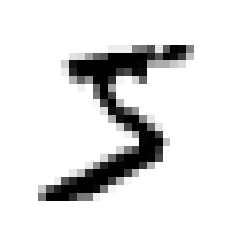

In [8]:
print_digit(X[0])

In [9]:
y[0]

5

In [10]:
# Target vectors for each set for value == 5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

## 3 First Model: Binary Classification

In [11]:
# Create pickles directory
os.makedirs(os.path.join(os.path.abspath('.'), 'pickles'), exist_ok=True)

In [12]:
# Stochastic Gradient Descent model for binary '5' classifier
from sklearn.linear_model import SGDClassifier

try:
    # Check for pickled model
    sgd_clf = pickle.load(open('pickles/sgd_clf.pkl', 'rb'))
except FileNotFoundError:
    # Create, train, and pickle the model if it does not exist
    sgd_clf = SGDClassifier(random_state=47)
    sgd_clf.fit(X_train, y_train_5)
    pickle.dump(sgd_clf, open('pickles/sgd_clf.pkl', 'wb'))

In [13]:
# Test 5 from above
sgd_clf.predict([X[0]])

array([ True])

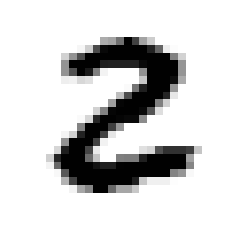

In [14]:
print_digit(X[25])

In [15]:
sgd_clf.predict([X[25]])

array([False])

## 4 First Model Evaluation

### 4.1 Cross-Validation

In [16]:
from sklearn.model_selection import cross_val_score

try:
    # Check for pickled cross validation scores
    sgd_cross_val_score = pickle.load(open('pickles/sgd_cross_val_score.pkl', 'rb'))
except FileNotFoundError:
    # Create and pickle the scores if the file does not exist
    sgd_cross_val_score = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')
    pickle.dump(sgd_cross_val_score, open('pickles/sgd_cross_val_score.pkl', 'wb'))

sgd_cross_val_score

array([0.9644 , 0.96595, 0.952  ])

In [17]:
# Very basic classifier for comparison
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [18]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

Only ~10% of the dataset is 5, so even if this model guessed 'not 5' every time it would still be ~90% accurate. This demonstrates that accuracy is not a great performance metric for classifiers.

### 4.2 Confusion Matrix

Record of the number of times class A is classified as class B.

In [19]:
# Visualization: Two of ten 'not-5' are classified as '5'
pd.DataFrame(np.array([[8,2],[0,0]]), columns=['not-5','5'], index=['not-5','5'])

,not-5,5
not-5,8,2
5,0,0


In [20]:
# Generate some predictions from the y_train_5 set
from sklearn.model_selection import cross_val_predict

try:
    # Check for pickled predictions
    y_train_pred = pickle.load(open('pickles/y_train_pred.pkl', 'rb'))
except FileNotFoundError:
    # Create and pickle the predictions if the file does not exist
    y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
    pickle.dump(y_train_pred, open('pickles/y_train_pred.pkl', 'wb'))

In [21]:
# Generate a confusion matrix using the predictions
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53852,   727],
       [ 1626,  3795]], dtype=int64)

A perfect classifier would contain non-zero values only along the main diagonal.

In [22]:
# Generate a confusion matrix for a 'perfect' classifier
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### 4.3 Precision and Recall

*Precision* is the accuracy of the positive predictions.

\begin{equation*}
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}}
\end{equation*}

*Recall* is the ratio of correctly detected positive instances.

\begin{equation*}
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}}
\end{equation*}

In [23]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8392304290137107

So when the model predicts a 5, it is correct 83.9% of the time.

In [24]:
recall_score(y_train_5, y_train_pred)

0.7000553403431101

Only 70% of the 5s are detected.

The F<sub>1</sub> score represents a combination (harmonic mean) of the precision and recall.

\begin{equation*}
F_1 
= \frac{2}{\frac{1}{Precision} + \frac{1}{Recall}} 
= \frac{\text{True Positives}}{\text{True Positives} + \frac{\text{False Negatives + False Positives}}{2}}
\end{equation*}

The F<sub>1</sub> score will only be high if both recall and precision are high.

In [25]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7633511012772803

### 4.4 Precision/Recall Trade-off

Achieving a high precision or recall score usually demands sacrificing one for the other. Depending on the application, an especially high precision score may be worth a poor recall score or vice versa.

- A high precision classifier would be more prone to missing true predictions, but would return very few false predictions.
- A high recall classifier would include more false predictions, but would be less likely to miss any true predictions.

In [26]:
# Decision scores are measured against a threshold to determine positive or negative classification
y_scores = sgd_clf.decision_function(X[:5])
y_scores

array([  1909.08072371, -10693.83133216, -14330.61396627,  -6577.95302654,
        -8273.37399553])

In [27]:
# SGDClassifier uses threshold 0
y_train_pred[:5]

array([ True, False, False, False, False])

To select an appropriate threshold for the application, it's useful to visualize the trade-off between precision and recall.

In [28]:
# Cross-validate using decision function to get scores instead of predictions
try:
    # Check for pickled scores
    y_scores = pickle.load(open('pickles/y_scores.pkl', 'rb'))
except FileNotFoundError:
    # Create and pickle the scores if the file does not exist
    y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
    pickle.dump(y_scores, open('pickles/y_scores.pkl', 'wb'))

In [49]:
# Create some visualizations for precision, recall, and thresholds
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

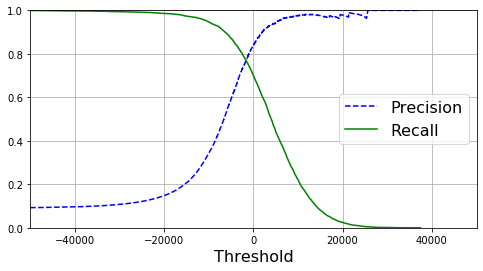

In [30]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

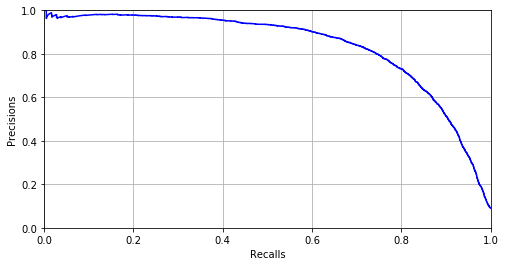

In [31]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-')
    plt.xlabel('Recalls')
    plt.ylabel('Precisions')
    plt.grid(True)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 4))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [64]:
# Helper function to get threshold necessary for target precision
def get_threshold_from_precision(thresholds, precisions, target):
    return thresholds[np.argmax(precisions >= target)]

# Another to print the results
def print_resulting_metrics(thresholds, precisions, target, scores=y_scores, train=y_train_5):
    target_threshold = get_threshold_from_precision(thresholds, precisions, target)
    y_train_pred_target = (scores >= target_threshold)
    print(
        f'Threshold: {target_threshold}\n'
        f'Precision: {precision_score(train, y_train_pred_target)}\n'
        f'Recall: {recall_score(train, y_train_pred_target)}'
    )

# Get a threshold for 90% precision and test it against predictions
print_resulting_metrics(thresholds, precisions, 0.9)

Threshold: 1952.503877999998
Precision: 0.9000273897562312
Recall: 0.6061612248662608


In [33]:
# Try 95%
print_resulting_metrics(thresholds, precisions, 0.95)

Threshold: 5310.608171242334
Precision: 0.9501022494887525
Recall: 0.4285187234827523


### 4.5 The ROC Curve

The ROC curve plots the *true positive rate* (*TPR* or *recall*) against the *false positive rate* (*FPR* or *1 - Specificity*), which is the ratio of negative instances that are incorrectly classified as positive.

\begin{align}
\text{FPR} & = \frac{\text{False Negatives}}{\text{True Negatives + False Negatives}}\\[10pt]
& = 1 - \frac{\text{True Negatives}}{\text{True Negatives + False Negatives}} \\[10pt]
& = 1 - \text{Specificity} \\[10pt]
\end{align}

In [34]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

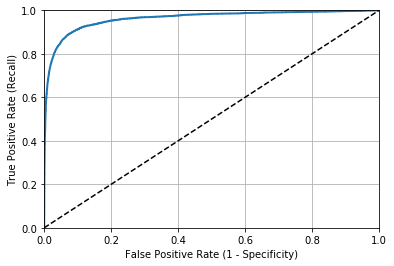

In [35]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.grid(True)
    plt.axis([0, 1, 0, 1])

plot_roc_curve(fpr, tpr)
plt.show()

- A good classifier will stay away from the diagonal, which represents an entirely random classifier.
- A perfect classifier would have an area under the curve (AUC) of 1.
- An entirely random classifier would have an AUC of 0.5.

In [36]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9621458763630213

**Note:** The ROC curve is useful for evaluating the number of false negatives, but the PR (precision vs. recall) curve is better for considering the number of false positives.

In [39]:
from sklearn.ensemble import RandomForestClassifier

try:
    # Check for pickled model
    forest_clf = pickle.load(open('pickles/forest_clf.pkl', 'rb'))
except FileNotFoundError:
    # Create and pickle the model if the file does not exist
    forest_clf = RandomForestClassifier(random_state=47)
    pickle.dump(forest_clf, open('pickles/forest_clf.pkl', 'wb'))

In [40]:
try:
    # Check for pickled predictions
    y_probas_forest = pickle.load(open('pickles/y_probas_forest.pkl', 'rb'))
except FileNotFoundError:
    # RandomForestClassifier doesn't have decision_function, but predict_proba returns probabilities
    y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')
    pickle.dump(y_probas_forest, open('pickles/y_probas_forest.pkl', 'wb'))

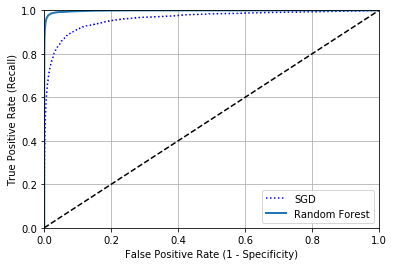

In [52]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [45]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983226319933023

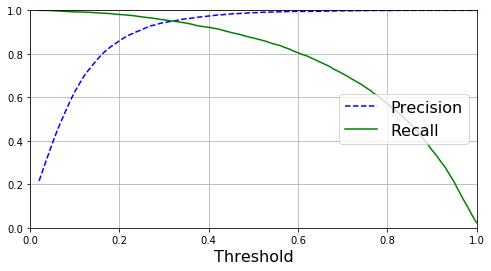

In [58]:
precisions_forest, recalls_forest, thresholds_forest_pr = precision_recall_curve(y_train_5, y_scores_forest)

def plot_forest_pr_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 4))
plot_forest_pr_vs_threshold(precisions_forest, recalls_forest, thresholds_forest_pr)
plt.show()

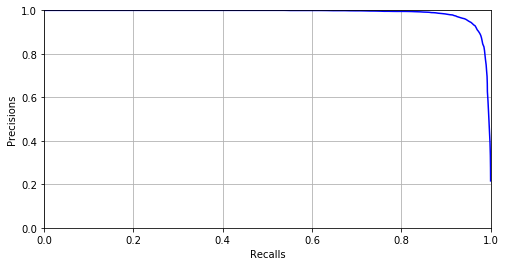

In [60]:
plt.figure(figsize=(8, 4))
plot_precision_vs_recall(precisions_forest, recalls_forest)
plt.show()

In [66]:
print_resulting_metrics(thresholds_forest_pr, precisions_forest, 0.99, scores=y_scores_forest)

Threshold: 0.52
Precision: 0.9910941475826972
Recall: 0.862202545655783


## 5 Second Model: Multiclass Classification

Some multiclass classification strategies:
- **One versus the rest (OvR)**: Train a binary classifier for each class (total N classifiers), get a score for each instance from each classifier, use the highest score to make a decision.
- **One versus one (OvO)**: Train a binary classifier for each *pair* of classes (total N * N - 1 classifiers), predict as above. Useful for splitting training set into smaller groups for faster training with algorithms that scale poorly with training set size (such as SVM).

In [90]:
# Scikit Learn will automatically select OvR or OvO according to the binary classification algorithm
from sklearn.svm import SVC

try:
    svm_clf = pickle.load(open('pickles/svm_clf.pkl', 'rb'))
except FileNotFoundError:
    svm_clf = SVC()
    # Train with the full training set, uses OvO for the SVM algorithm
    svm_clf.fit(X_train, y_train)
    pickle.dump(svm_clf, open('pickles/svm_clf.pkl', 'wb'))
    
svm_clf.predict([X[0]]) # 5

array([5], dtype=uint8)

In [71]:
digit_scores = svm_clf.decision_function([X[0]])
digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [72]:
# Check the index of the highest score
np.argmax(digit_scores)

5

In [73]:
# Check the class at the highest score
svm_clf.classes_[np.argmax(digit_scores)]

5

In [74]:
# You can force a strategy by wrapping the classifier in a OneVsOneClassifier or a OneVsRestClassifier
from sklearn.multiclass import OneVsRestClassifier

try:
    ovr_clf = pickle.load(open('pickles/ovr_clf.pkl', 'rb'))
except FileNotFoundError:
    ovr_clf = OneVsRestClassifier(SVC())
    # Train with the full training set, uses OvR
    ovr_clf.fit(X_train, y_train)
    pickle.dump(ovr_clf, open('pickles/ovr_clf.pkl', 'wb'))

ovr_clf.predict([X[0]]) # 5

In [78]:
len(ovr_clf.estimators_)

10

In [79]:
# SGD and Random Forest classifiers can directly classify instances into multiple classes
sgd_clf.fit(X_train, y_train)
pickle.dump(sgd_clf, open('pickles/sgd_clf.pkl', 'wb'))

sgd_clf.predict([X[0]]) # 5

array([5], dtype=uint8)

In [80]:
# Check the score of each class
sgd_clf.decision_function([X[0]])

array([[-23592.02189761, -32735.56718728,  -8380.60884311,
           937.72111519, -29838.45551128,   7209.67394061,
        -20857.0863882 , -15358.53716793,  -8264.22025439,
        -11883.02600923]])

In [81]:
# Cross-validate the classifier
try:
    sgd_clf_scores = pickle.load(open('pickles/sgd_clf_scores.pkl', 'rb'))
except FileNotFoundError:
    sgd_clf_scores = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')
    pickle.dump(sgd_clf_scores, open('pickles/sgd_clf_scores.pkl', 'wb'))

sgd_clf_scores

array([0.88335, 0.8642 , 0.8838 ])

In [82]:
# Scale the inputs to improve the accuracy
from sklearn.preprocessing import StandardScaler

# Transform the training data
try:
    X_train_scaled = pickle.load(open('pickles/X_train_scaled.pkl', 'rb'))
except FileNotFoundError:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
    pickle.dump(X_train_scaled, open('pickles/X_train_scaled.pkl', 'wb'))

# Cross-validate once more
try:
    sgd_clf_scores_scaled = pickle.load(open('pickles/sgd_clf_scores_scaled.pkl', 'rb'))
except FileNotFoundError:
    sgd_clf_scores_scaled = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')
    pickle.dump(sgd_clf_scores_scaled, open('pickles/sgd_clf_scores_scaled.pkl', 'wb'))

sgd_clf_scores_scaled

array([0.90165, 0.89425, 0.9073 ])

## 6 Error Analysis

In [91]:
# Make predictions using the multiclass classifier
try:
    y_train_pred_mc = pickle.load(open('pickles/y_train_pred_mc.pkl', 'rb'))
except FileNotFoundError:
    y_train_pred_mc = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
    pickle.dump(y_train_pred_mc, open('pickles/y_train_pred_mc.pkl', 'wb'))

# Generate a confusion matrix
conf_mx = confusion_matrix(y_train, y_train_pred_mc)
conf_mx

array([[5596,    0,   24,    5,    9,   52,   36,    6,  194,    1],
       [   0, 6408,   38,   25,    4,   46,    4,    8,  194,   15],
       [  28,   27, 5250,   94,   72,   28,   69,   41,  339,   10],
       [  24,   17,  118, 5250,    2,  219,   27,   40,  361,   73],
       [  12,   15,   50,   12, 5208,   13,   39,   25,  295,  173],
       [  28,   16,   32,  170,   55, 4494,   78,   17,  466,   65],
       [  29,   15,   46,    2,   42,  100, 5564,    5,  114,    1],
       [  20,   10,   52,   31,   49,   13,    3, 5716,  157,  214],
       [  20,   66,   46,   88,    3,  127,   28,   11, 5415,   47],
       [  23,   19,   30,   66,  117,   41,    1,  179,  310, 5163]],
      dtype=int64)

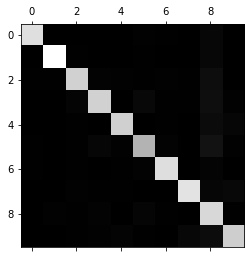

In [92]:
# Visualize the matrix
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

**Reminder**: Values along the main diagonal indicate correct classification.

In [93]:
# Normalize the matrix to get error rates rather than number of errors
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

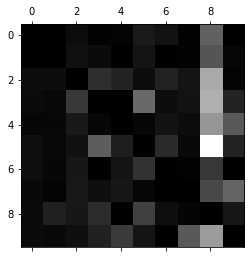

In [94]:
# Fill diagonal with zeros so only errors remain
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Some observations:
- Many images are misclassified as 8s, but 8s are typically classified correctly.
- 3s and 5s tend to be misclassified as each other.

In [88]:
# Helper function from the book
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

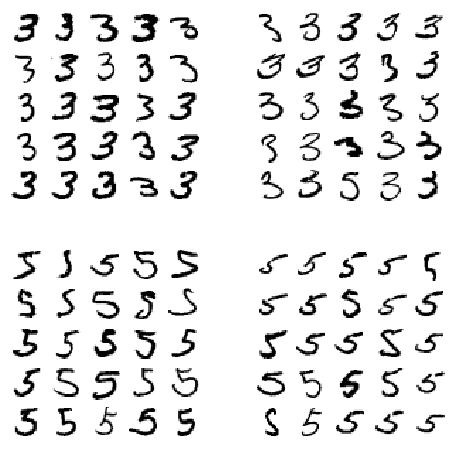

In [95]:
# Visualize some of the 3s and 5s to get an idea why they may be confused
cl_a, cl_b = 3, 5

# Correctly classified 3s
X_aa = X_train[(y_train == cl_a) & (y_train_pred_mc == cl_a)]

# Misclassified 3s
X_ab = X_train[(y_train == cl_a) & (y_train_pred_mc == cl_b)]

# Misclassified 5s
X_ba = X_train[(y_train == cl_b) & (y_train_pred_mc == cl_a)]

# Correctly classified 5s
X_bb = X_train[(y_train == cl_b) & (y_train_pred_mc == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## 7 Additional Topics

### 7.1 Multilabel Classification

Multilabel classification systems are designed to output multiple binary tags indicating a positive or negative classification for their respective classes. Example: [0,1,1] for a negative A and positive B and C.

In [98]:
from sklearn.neighbors import KNeighborsClassifier

# Training set for values that are 7, 8, or 9
y_train_large = (y_train >= 7)

# Training set for odd values
y_train_odd = (y_train %2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

try:
    knn_clf = pickle.load(open('pickles/knn_clf.pkl', 'rb'))
except FileNotFoundError:
    knn_clf = KNeighborsClassifier()
    knn_clf.fit(X_train, y_multilabel)
    pickle.dump(knn_clf, open('pickles/knn_clf.pkl', 'wb'))

knn_clf.predict([X[0]]) # Should be [False, True] because 5 is not >= 7 and it is odd

array([[False,  True]])

One evaluation strategy for multilabel classifiers is to determine the F<sub>1</sub> score (or another binary classifier metric) for each label and average them.

In [99]:
# Calculate the multilabel predictions and determine the F1 score
try:
    y_train_knn_pred = pickle.load(open('pickles/y_train_knn_pred.pkl', 'rb'))
except FileNotFoundError:
    y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
    pickle.dump(y_train_knn_pred, open('pickles/y_train_knn_pred.pkl', 'wb'))

f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

In [100]:
# Use 'weighted' average to apply weights proportional to the instances in each label
f1_score(y_multilabel, y_train_knn_pred, average='weighted')

0.9778357403921755

### 7.2 Multioutput Classification

Multioutput classification is a generalization of multiclass classification where each label can have more than two possible values.

In [102]:
# Function to generate random noise in the shape of our images 
def make_noise(data):
    return np.random.randint(0, 100, (len(data), 784))

# Add noise to MNIST images
X_train_mod = X_train + make_noise(X_train)
X_test_mod = X_test + make_noise(X_test)
y_train_mod = X_train
y_test_mod = X_test

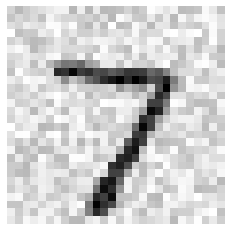

In [103]:
print_digit(X_test_mod[0])

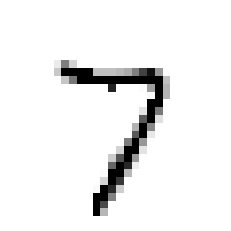

In [104]:
# Train the KNN classifier to clean the data
try:
    knn_clf_cleaner = pickle.load(open('pickles/knn_clf_cleaner.pkl', 'rb'))
except FileNotFoundError:
    knn_clf_cleaner = KNeighborsClassifier()
    knn_clf_cleaner.fit(X_train_mod, y_train_mod)
    pickle.dump(knn_clf_cleaner, open('pickles/knn_clf_cleaner.pkl', 'wb'))

clean_digit = knn_clf_cleaner.predict([X_test_mod[0]])
print_digit(clean_digit)